# Localization Using Stereo Reprojection Error
#### T D Barfoot, September 2022
In this notebook we solve a stereo localization problem as a Semi-Definite Program (SDP).
$\newcommand{\bbm}{\begin{bmatrix}}$
$\newcommand{\ebm}{\end{bmatrix}}$
$\def\mbf#1{\mathbf{#1}}$
$\def\mbs#1{\boldsymbol{#1}}$

In [1]:
import math
import numpy as np
import scipy
from numpy import linalg as la
import os
import matplotlib.pyplot as plot

#import sys
#!{sys.executable} -m pip install mosek
#import mosek
#os.environ['MOSEKLM_LICENSE_FILE'] = 'mosek.lic'  # put license file in same directory as this notebook

import cvxpy as cp
print(cp.installed_solvers())


['ECOS', 'ECOS_BB', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


Starting from a known pose, $\mbf{T}$, and landmarks, $\mbf{p}_j$ we produce measurements according to

$$ \mbf{y}_{j} = \mbf{M} \frac{1}{z_j} \mbf{T} \mbf{p}_j + \mbf{n}_j $$

where $\mbf{n}_{j} \sim \mathcal{N}(\mbf{0}, \mbf{W}_{j}^{-1})$ is Gaussian noise and $z_j = \mbf{a}^T \mbf{T} \mbf{p}_j$ with $\mbf{a}^T = \bbm 0 & 0 & 1 & 0 \ebm$.  After this we can state the problem we want to solve.

In [21]:
# groundtruth pose
Ttrue = np.matrix([[1, 0, 0, 0.2], [0, 1, 0, 0], [0, 0, 1, 1.2], [0, 0, 0, 1]])  

# groundtruth landmarks
J = 5;
p = np.zeros((J,4,1))
p[0,:,:] = np.matrix('1; 1; 2; 1')
p[1,:,:] = np.matrix('1; -1; 2; 1')
p[2,:,:] = np.matrix('-1; 1; 2; 1')
p[3,:,:] = np.matrix('-1; -1; 2; 1')
p[4,:,:] = np.matrix('0; 0; 3; 1')

# constant projection matrices for dealing with "z" coordinate and other things
a = np.matrix('0; 0; 1; 0')
Pu = np.matrix([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 0, 1]])

# constant camera matrix
b = 0.2
fu = 100
fv = 100
cu = 50
cv = 50
M = np.matrix([[fu, 0, cu, fu*b/2], [0, fv, cv, 0], [fu, 0, cu, -fu*b/2], [0, fv, cv, 0]]) 

# generate measurements with small amount of noise
y = np.zeros((J,4,1))
for j in range(J):
    y[j,:,:] = M @ Ttrue @ p[j,:,:] / (a.T @ Ttrue @ p[j,:,:]) + 0.01*np.vstack((np.random.randn(3,1), 0))
    # print(y[j,:,:])

The first version of our optimization problem is

$$ \begin{array}{rl}\min & \underbrace{\gamma (\mbf{d} - \mbf{T} \mbf{d})^T (\mbf{d} - \mbf{T} \mbf{d})}_{\mbox{position prior}} + \underbrace{\sum_j ( \mbf{y}_j - \mbf{M} \frac{1}{z_j} \mbf{T} \mbf{p}_j )^T ( \mbf{y}_j - \mbf{M} \frac{1}{z_j} \mbf{T} \mbf{p}_j )}_{\mbox{measurements}} \\ \mbox{w.r.t.} & \mbf{T} \\ \mbox{s.t.} & \mbf{C}^T \mbf{C} = \mbf{I} \end{array}$$

where $z_j = \mbf{a}^T \mbf{T} \mbf{p}_j$, $ \mbf{a}^T = \bbm 0 & 0 & 1 & 0 \ebm$, $\mbf{d}^T = \bbm 0 & 0 & 0 & 1 \ebm$, and there are also some constraints on the bottom row of $\mbf{T} = \bbm \mbf{C} & \mbf{r} \\ \mbf{0}^T & 1 \ebm$.  We then make the substitution $\mbf{v}_j = \frac{1}{z_j} \mbf{T} \mbf{p}_j$, which can be rewritten as a quadratic constraint:  $( \mbf{I} - \mbf{v}_j \mbf{a}^T ) \mbf{T} \mbf{p}_j = \mbf{0}$.  Our optimization problem then becomes a QCQP:

$$ \begin{array}{rl}\min & \gamma (\mbf{d} - \mbf{T} \mbf{d})^T (\mbf{d} - \mbf{T} \mbf{d}) + \sum_j ( \mbf{y}_j - \mbf{v}_j )^T ( \mbf{y}_j - \mbf{v}_j ) \\ \mbox{w.r.t.} & \mbf{T}, \mbf{v}_j \\ \mbox{s.t.} & (\forall j) \; ( \mbf{I} - \mbf{v}_j \mbf{a}^T ) \mbf{T} \mbf{p}_j = \mbf{0} \\ & \mbf{C}^T \mbf{C} = \mbf{I} \end{array}$$

Next, we will eliminate the constant bottom row of $\mbf{T}$, $\bbm 0 & 0 & 0 & 1 \ebm$, and the third element of each $\mbf{v}_j$, which is $1$.  Suppose that

$$ \mbf{T} = \bbm \mbf{c}_1 & \mbf{c}_2 & \mbf{c}_3 & \mbf{r} \\ 0 & 0 & 0 & 1 \ebm $$

Then we let

$$ \mbf{t} = \bbm \mbf{c}_1 \\ \mbf{c}_2 \\ \mbf{c}_3 \\ \mbf{r} \ebm $$ 

so that

$$ \mbox{vec}(\mbf{T}) = \mbf{P}_t^T \mbf{t} + \mbf{b} $$

where $\mbf{P}_t$ is a $12 \times 16$ projection matrix and $\mbf{b}$ is a $16 \times 1$ column with all zeros except the bottom entry.  We also let

$$ \mbf{v}_j = \mbf{P}_u^T \mbf{u}_j + \mbf{a} $$

where $\mbf{P}_u$ is a $3 \times 4$ projection matrix.  The minimal set of variables to optimize is then

$$ \mbf{x} = \bbm \mbf{t} \\ \mbf{u}_1 \\ \vdots \\ \mbf{u}_J \\ \omega_0 \ebm $$ 

In terms of these variables, the optimization problem becomes

$$ \begin{array}{rl}\min & \gamma \mbf{r}^T \mbf{r} + \sum_j ( \omega_0 (\mbf{y}_j - \mbf{M} \mbf{a}) - \mbf{M} \mbf{P}_u^T \mbf{u}_j )^T ( \omega_0 (\mbf{y}_j - \mbf{M} \mbf{a}) - \mbf{M} \mbf{P}_u^T \mbf{u}_j ) \\ \mbox{w.r.t.} & \mbf{t}, \mbf{u}_j, \omega_0 \\ \mbox{s.t.} & (\forall j) \; ( \omega_0 ( \mbf{I} - \mbf{a}\mbf{a}^T) - \mbf{P}_u^T \mbf{u}_j \mbf{a}^T) ( \mbf{p}_j^T \otimes \mbf{I})(\mbf{P}_t^T \mbf{t} + \omega_0 \mbf{b}) = \mbf{0} \\ & \mbf{C}^T \mbf{C} = \mbf{I} \\ & \omega_0^2 = 1 \end{array}$$

where we use that $\mbf{T}\mbf{p}_j = (\mbf{p}_j^T \otimes \mbf{I}) \mbox{vec}(\mbf{T})$.

The whole problem can be stated in the form

$$ \begin{array}{rl}\min & \mbf{x}^T \mbf{Q} \mbf{x} \\ \mbox{w.r.t.} & \mbf{x} \\ \mbox{s.t.} & (\forall i,j) \; \mbf{x}^T \mbf{A}_{ij} \mbf{x} = c_{ij} \end{array}$$

for some $\mbf{Q}$, $\mbf{A}_{ij}$, $c_{ij}$ and then relaxed to an SDP:

$$ \begin{array}{rl}\min & \mbox{tr}(\mbf{Q} \mbf{X} ) \\ \mbox{w.r.t.} & \mbf{X} \\ \mbox{s.t.} & \mbf{X} \geq 0 \\ & (\forall i,j) \; \mbox{tr}(\mbf{A}_{ij} \mbf{X}) = c_{ij} \end{array}$$

The substitution constraint can be manipulated a bit further to avoid computing the $\mbf{A}_{ij}$ explicitly. Premultiplying by $\mbf{e}_i^T$, the $i$th column of the $4 \times 4$ identity matrix, it can be arranged as

$$ (\forall i,j) \; \mbf{e}_i^T( \mbf{I} - \mbf{a}\mbf{a}^T) ( \mbf{p}_j^T \otimes \mbf{I} ) ( \mbf{P}_t^T \underbrace{\mbf{t} \omega_0}_{\mbf{X}_{1:12,12+3J+1}} + \underbrace{\omega_0^2}_{1} \mbf{b}) = \mbf{a}^T ( \mbf{p}_j^T \otimes \mbf{I} ) ( \mbf{P}_t^T \underbrace{\mbf{t} \mbf{u}_k^T}_{\mbf{X}_{1:12,12+3j+1:12+3j+3}} \mbf{P}_u \mbf{e}_i + \mbf{e}_i^T \mbf{P}_u^T \underbrace{\mbf{u}_j \omega_0}_{\mbf{X}_{12+3j+1:12+3j+3,12+3J+1}} \mbf{b}) $$

which may be easer to implement in the solver using the identified blocks of $\mbf{X}$.  

In [22]:
# solve the problem using a local solver

# odot operator for homogeneous points
def odot(p):
    podot = np.zeros((4,6))
    podot[0,0] = p[3,0]
    podot[1,1] = p[3,0]
    podot[2,2] = p[3,0]
    podot[0,4] = -p[2,0]
    podot[0,5] = p[1,0]
    podot[1,5] = -p[0,0]
    podot[1,3] = p[2,0]
    podot[2,3] = -p[1,0]
    podot[2,4] = p[0,0]
    return podot

# wdg operator for se(3) vectors
def wdg(xi):
    xiwdg = np.zeros((4,4))
    xiwdg[0,1] = xi[5,0]
    xiwdg[0,2] = -xi[4,0]
    xiwdg[1,2] = xi[3,0]
    xiwdg[1,0] = -xi[5,0]
    xiwdg[2,0] = xi[4,0]
    xiwdg[2,1] = -xi[3,0]
    xiwdg[0,3] = xi[0,0]
    xiwdg[1,3] = xi[1,0]
    xiwdg[2,3] = xi[2,0]
    return xiwdg

# initial guess
T = np.eye(4)

# for prior on position
d = np.matrix('0; 0; 0; 1')
gamma = 0.01

for i in range(100):
    LHS = gamma * odot( T @ d ).T @ odot( T @ d )
    RHS = gamma * odot( T @ d ).T @ ( d - T @ d )
    for j in range(J):
        zj = a.T @ T @ p[j,:,:]
        ej = y[j,:,:] - M @ T @ p[j,:,:] / zj      
        Ej = M @ ( np.eye(4) - T @ p[j,:,:] @ a.T / zj ) @ odot( T @ p[j,:,:] ) / zj
        
        LHS += Ej.T @ Ej
        RHS += Ej.T @ ej
        
    x = la.solve(LHS,RHS)    
    T = scipy.linalg.expm( wdg(x) ) @ T
    
print(T)

# check the cost
local_cost = gamma*(d - T @ d).T @ (d - T @ d)
for j in range(J):
    zj = a.T @ T @ p[j,:,:]
    ej = y[j,:,:] - M @ T @ p[j,:,:] / zj
    local_cost += ej.T @ ej

print(local_cost)
    

[[ 9.99999983e-01 -1.02548890e-04 -1.51057989e-04  2.00308176e-01]
 [ 1.02494716e-04  9.99999930e-01 -3.58589095e-04  8.29244527e-04]
 [ 1.51094751e-04  3.58573607e-04  9.99999924e-01  1.19988017e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[0.0160557]]


[[0.0160557]]


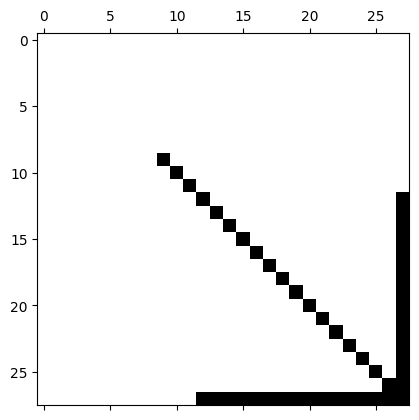

In [23]:
# set up the data matrix
N = 12 + 3*J + 1 

Q = np.zeros((N,N))
Q[9,9] = gamma
Q[10,10] = gamma
Q[11,11] = gamma

for j in range(J):
    Q[12+3*j:12+3*(j+1),12+3*j:12+3*(j+1)] = Pu @ M.T @ M @ Pu.T
    Q[12+3*j:12+3*(j+1),[N-1]] = -Pu @ M.T @ ( y[j,:,:] - M @ a )
    Q[[N-1],12+3*j:12+3*(j+1)] = -( y[j,:,:].T - a.T @ M.T ) @ M @ Pu.T
    Q[[N-1],[N-1]] = Q[[N-1],[N-1]] + ( y[j,:,:].T - a.T @ M.T ) @ ( y[j,:,:] - M @ a )

    
# check the cost matches the local solver cost
v = np.zeros((J,4,1))
for j in range(J):
    v[j,:,:] = T @ p[j,:,:] / (a.T @ T @ p[j,:,:])
       
x = np.vstack((T[0:3,0:1],T[0:3,1:2],T[0:3,2:3],T[0:3,3:4],Pu*v[0,:,:],Pu*v[1,:,:],Pu*v[2,:,:],Pu*v[3,:,:],Pu*v[4,:,:],1))
print( x.T @ Q @ x )

Xlocal = x @ x.T;

# plot the sparsity pattern of the data matrix
Qplt = np.zeros((N,N,3))
Qplt[abs(Q)<1e-50] = [1,1,1]
plot.matshow(Qplt, cmap='Greys')
plot.show()    

In [24]:
# set up the problem as an SDP
X = cp.Variable((N,N), symmetric=True)
objective = cp.Minimize( cp.trace( Q @ X ) )

# PSD constraint
constraints = [ X >> 0 ]

# homogenization variable constraint
constraints += [ X[N-1,N-1] == 1 ]

# rotation matrix constraints
constraints += [cp.trace(X[0:3,0:3]) == 1, cp.trace(X[3:6,3:6]) == 1, cp.trace(X[6:9,6:9]) == 1, 
                cp.trace(X[3:6,0:3]) == 0, cp.trace(X[6:9,0:3]) == 0, cp.trace(X[6:9,3:6]) == 0 ]

# some constants to help
Pt = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]])
bt = np.zeros((16,1))
bt[15,0] = 1

# substitution constraints
I = np.eye(4)
for j in range(J):
    for k in range(4):
        if k != 2:
            constraints += [ I[:,k].T @ (I - a @ a.T) @ np.kron( p[j,:,:].T, I ) @ ( Pt.T @ X[0:12,N-1:N] + bt ) 
                         == a.T @ np.kron( p[j,:,:].T, I ) @ Pt.T @ X[0:12,12+3*j:12+3*(j+1)] @ Pu @ I[:,k] + I[:,k].T @ Pu.T @ X[12+3*j:12+3*(j+1),N-1:N] @ a.T @ np.kron( p[j,:,:].T, I ) @ bt ]
        
        # check the constraints are satisfied by the local solution
        #print( I[:,k].T @ (I - a @ a.T) @ np.kron( p[j,:,:].T, I ) @ ( Pt.T @ Xlocal[0:12,N-1:N] + bt ) 
        #                 - a.T @ np.kron( p[j,:,:].T, I ) @ Pt.T @ Xlocal[0:12,12+3*j:12+3*(j+1)] @ Pu @ I[:,k] + I[:,k].T @ Pu.T @ Xlocal[12+3*j:12+3*(j+1),N-1:N] @ a.T @ np.kron( p[j,:,:].T, I ) @ bt  )

# redundant constraints:  v_k (T p_k)^T == (T p_k) v_k^T 
#for j in range(J):
#    constraints += [  np.kron( p[j,:,:].T, I ) @ ( Pt.T @ X[0:12,12+3*j:12+3*(j+1)] @ Pu + bt @ X[N-1:N,12+3*j:12+3*(j+1)] @ Pu + Pt.T @ X[0:12,N-1:N] @ a.T + bt @ a.T)
#                      == (Pu.T @ X[12+3*j:12+3*(j+1),0:12] @ Pt + Pu.T @ X[12+3*j:12+3*(j+1),N-1:N] @ bt.T + a @ X[N-1:N,0:12] @ Pt + a @ bt.T) @ np.kron( p[j,:,:], I ) ]
        
prob = cp.Problem(objective,constraints)

# solve the SDP
prob.solve(solver=cp.MOSEK, verbose=True)

print(prob.value)
print(prob.status)        
        

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Oct 06 10:00:49 PM: Your problem has 784 variables, 23 constraints, and 0 parameters.
(CVXPY) Oct 06 10:00:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 06 10:00:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 06 10:00:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 06 10:00:49 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Oct 06 10:00:49 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

(CVXPY) Oct 06 10:00:50 PM: Optimal value: 1.555e-02
(CVXPY) Oct 06 10:00:50 PM: Compilation took 1.447e-01 seconds
(CVXPY) Oct 06 10:00:50 PM: Solver (including time spent in interface) took 1.358e-01 seconds
0.015547051169944065
optimal


0.015547051169944065


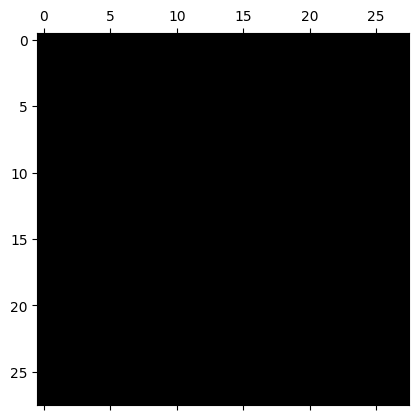

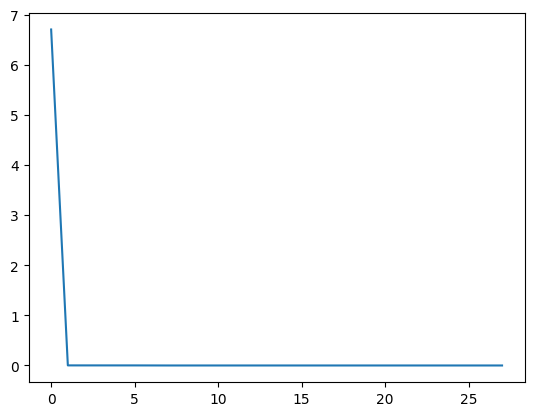

[6.70383074e+00 1.82008091e-03 1.49745777e-03 1.45823380e-03
 1.35780980e-03 1.32587596e-03 6.66145121e-04 2.76577809e-06
 1.30342678e-06 1.28295029e-06 4.26614384e-07 4.12760097e-07
 3.61791114e-07 8.02059687e-11 6.83218036e-11 6.27585723e-11
 6.27504372e-11 1.74142628e-11 2.07066334e-12 1.78199967e-12
 1.78185683e-12 1.78184592e-12 1.78182103e-12 1.78180047e-12
 1.78178170e-12 1.78177767e-12 1.78172221e-12 1.78131207e-12]
[ 9.97815162e-01  1.36969155e-04  2.68990921e-05 -6.42259417e-05
  9.97976895e-01  4.12653195e-04 -8.93914682e-05 -3.38410022e-04
  9.99998113e-01  1.99738135e-01  8.01149872e-04  1.19320106e+00]


In [25]:
# extract the output of the solver
Xout = X.value

# verify the cost matches the solver's output
print( np.trace(Q @ Xout) )

# plot the sparsity of the X matrix (should look dense for rank 1)
Xplt = np.zeros((N,N,3))
Xplt[abs(Xout)<1e-50] = [1,1,1]
plot.matshow(Xplt, cmap='Greys')
plot.show()

# extract the eigenvalues of the X matrix to examine the rank
U, S, V = np.linalg.svd(Xout, hermitian=True)
plot.plot(S)
plot.show()
print(S)

# print out the solution for "t", which is the pose
print(Xout[0:12,N-1])
